In [2]:
import functools
import os
import typing

import joblib
import networkx as nx
import numpy as np
import pandas as pd
import dcor
from scipy.stats import pearsonr, ttest_rel
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.utils import check_random_state
from tqdm.auto import tqdm
from scipy import stats
from scipy.stats import entropy
import pandas as pd
import pingouin as pg

from scipy.spatial.distance import pdist, squareform
import numpy as np

e:\Softwares\Anaconda\CondaEnvs\casual\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import crunch
crunch = crunch.load_notebook()

loaded inline runner with module: <module '__main__'>


In [4]:
def graph_nodes_representation(graph, nodelist):
    """
    Create an alternative representation of a graph which is hashable
    and equivalent graphs have the same hash.

    Python cannot PROPERLY use nx.Graph/DiGraph as key for
    dictionaries, because two equivalent graphs with just different
    order of the nodes would result in different keys. This is
    undesirable here.

    So here we transform the graph into an equivalent form that is
    based on a specific nodelist and that is hashable. In this way,
    two equivalent graphs, once transformed, will result in identical
    keys.

    So we use the following trick: extract the adjacency matrix
    (with nodes in a fixed order) and then make a hashable thing out
    of it, through tuple(array.flatten()):
    """

    # This get the adjacency matrix with nodes in a given order, as
    # numpy array (which is not hashable):
    adjacency_matrix = nx.adjacency_matrix(graph, nodelist=nodelist).todense()

    # This transforms the numpy array into a hashable object:
    hashable = tuple(adjacency_matrix.flatten())

    return hashable

def create_graph_label():
    """
    Create a dictionary from graphs to labels, in two formats.
    """
    graph_label = {
        nx.DiGraph([("X", "Y"), ("v", "X"), ("v", "Y")]): "Confounder",
        nx.DiGraph([("X", "Y"), ("X", "v"), ("Y", "v")]): "Collider",
        nx.DiGraph([("X", "Y"), ("X", "v"), ("v", "Y")]): "Mediator",
        nx.DiGraph([("X", "Y"), ("v", "X")]):             "Cause of X",
        nx.DiGraph([("X", "Y"), ("v", "Y")]):             "Cause of Y",
        nx.DiGraph([("X", "Y"), ("X", "v")]):             "Consequence of X",
        nx.DiGraph([("X", "Y"), ("Y", "v")]):             "Consequence of Y",
        nx.DiGraph({"X": ["Y"], "v": []}):                "Independent",
    }

    nodelist = ["v", "X", "Y"]

    # This is an equivalent alternative to graph_label but in a form
    # for which two equivalent graphs have the same key:
    adjacency_label = {
        graph_nodes_representation(graph, nodelist): label
        for graph, label in graph_label.items()
    }

    return graph_label, adjacency_label

def get_labels(adjacency_matrix, adjacency_label):
    """
    Transform an adjacency_matrix (as pd.DataFrame) into a dictionary of variable:label
    """

    result = {}
    for variable in adjacency_matrix.columns.drop(["X", "Y"]):
        submatrix = adjacency_matrix.loc[[variable, "X", "Y"], [variable, "X", "Y"]]  # this is not hashable
        key = tuple(submatrix.values.flatten())  # this is hashable and a compatible with adjacency_label
    
        result[variable] = adjacency_label[key]

    return result

graph_label, adjacency_label = create_graph_label()

In [5]:
X_train, y_train, X_test = crunch.load_data()

download data\X_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_train.pickle (1523944532 bytes)
already exists: file length match
download data\y_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_train.pickle (7017735 bytes)
already exists: file length match
download data\X_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_test_reduced.pickle (122341879 bytes)
already exists: file length match
download data\y_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_test_reduced.pickle (562930 bytes)
already exists: file length match
download data\example_prediction.parquet from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/example_prediction_reduced.parquet (668981 bytes)
already exists: file length match


In [6]:
def pearson_correlation(dataset):
    """
    Given a dataset, we compute the correlation-based features for each
    varibale, which are the correlation between that variable with X and Y,
    as well as summary statistics (max, min, mean, std) of all pairs
    of correlations.
    """

    variables = dataset.columns.drop(["X", "Y"])

    df = []
    for variable in variables:
        tmp = dataset.corr().drop([variable], axis="columns").loc[variable].abs()

        df.append({
            "variable": variable,
            "corr(v,X)": dataset[[variable, "X"]].corr().loc[variable, "X"],
            "corr(v,Y)": dataset[[variable, "Y"]].corr().loc[variable, "Y"],
            "max(corr(v, others))": tmp.max(),
            "min(corr(v, others))": tmp.min(),
            "mean(corr(v, others))": tmp.mean(),
            "std(corr(v, others))": tmp.std(),
        })

    df = pd.DataFrame(df)
    df["dataset"] = dataset.name

    df["corr(X,Y)"] = dataset[["X", "Y"]].corr().loc["X", "Y"]

    # pearsonr is NaN when the variance is 0, so we fill with 0
    df.fillna(0, inplace=True)

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

def ttest(dataset, pvalue_threshold=0.05):
    """
    Given a dataset, this function computes the t-test between the
    values each variable v and X, Y. The t value and the result of the
    t-test with a given pvalue_threshold, are used to create features
    to describe/embed v, as well as the t-test result between the
    values of X and Y.
    """

    variables = dataset.columns.drop(["X", "Y"])

    df = []
    for variable in variables:
        ttest_vX = ttest_rel(dataset[variable], dataset["X"])
        ttest_vY = ttest_rel(dataset[variable], dataset["Y"])

        df.append({
            "variable": variable,
            "ttest(v,X)": ttest_vX.statistic,
            f"pvalue(ttest(v,X))<={pvalue_threshold}": (ttest_vX.pvalue <= pvalue_threshold).astype(float),
            "ttest(v,Y)": ttest_vY.statistic,
            f"pvalue(ttest(v,Y))<={pvalue_threshold}": (ttest_vY.pvalue <= pvalue_threshold).astype(float),
        })

    df = pd.DataFrame(df)
    df["dataset"] = dataset.name

    ttest_XY = ttest_rel(dataset["X"], dataset["Y"])
    df["ttest(X,Y)"] = ttest_XY.statistic
    df[f"pvalue(ttest(X,Y))<={pvalue_threshold}"] = (ttest_XY.pvalue <= pvalue_threshold).astype(float)

    # some the ttest returns NaN when the variance is 0, so we fill with 0:
    df.fillna(0, inplace=True)

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

def mutual_information(dataset):
    """
    Given a dataset, we compute the mutual-information-based features
    for each varibale, which are the correlation between that variable
    X and Y, as well as summary statistics (max, min, mean, std) of
    all pairs of correlations.
    """

    variables = dataset.columns.drop(["X", "Y"])

    df = []
    for variable in variables:
        tmp = mutual_info_regression(dataset.drop(columns=[variable]), dataset[variable])

        df.append({
            "variable": variable,
            "MI(v,X)": mutual_info_regression(dataset[[variable]], dataset["X"], discrete_features=False)[0],
            "MI(v,Y)": mutual_info_regression(dataset[[variable]], dataset["Y"], discrete_features=False)[0],
            "max(MI(v, others))": tmp.max(),
            "min(MI(v, others))": tmp.min(),
            "mean(MI(v, others))": tmp.mean(),
            "std(MI(v, others))": tmp.std(),
        })

    df = pd.DataFrame(df)
    df["dataset"] = dataset.name

    df["MI(X,Y)"] = mutual_info_regression(dataset[["X"]], dataset["Y"], discrete_features=False)[0]

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

def add_dimension_feature(dataset):
    """
    Add a dimension feature to the dataset.
    """
    variables = dataset.columns.drop(["X", "Y"])
    dimension = len(variables)
    square_dimension = dimension * dimension
    df = pd.DataFrame({
        "variable": variables,
        "dimension": dimension,
        "square_dimension": square_dimension
    })
    df["dataset"] = dataset.name
    
    return df

def spearman_correlation(dataset):
    """
    Given a dataset, we compute the Spearman rank correlation-based features for each
    variable, which are the Spearman correlation between that variable with X and Y,
    as well as summary statistics (max, min, mean, std) of all pairs of Spearman correlations.
    """
    variables = dataset.columns.drop(["X", "Y"])

    df = []
    for variable in variables:
        tmp = dataset.corr(method='spearman').drop([variable], axis="columns").loc[variable].abs()

        df.append({
            "variable": variable,
            "spearman_corr(v,X)": dataset[[variable, "X"]].corr(method='spearman').loc[variable, "X"],
            "spearman_corr(v,Y)": dataset[[variable, "Y"]].corr(method='spearman').loc[variable, "Y"],
            "max(spearman_corr(v, others))": tmp.max(),
            "min(spearman_corr(v, others))": tmp.min(),
            "mean(spearman_corr(v, others))": tmp.mean(),
            "std(spearman_corr(v, others))": tmp.std(),
        })

    df = pd.DataFrame(df)
    df["dataset"] = dataset.name

    df["spearman_corr(X,Y)"] = dataset[["X", "Y"]].corr(method='spearman').loc["X", "Y"]

    # Spearman correlation is NaN when there are ties in rank, so we fill with 0
    df.fillna(0, inplace=True)

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

def kendall_correlation(dataset):
    """
    Given a dataset, we compute the Kendall's tau correlation-based features for each
    variable, which are the Kendall's tau correlation between that variable with X and Y,
    as well as summary statistics (max, min, mean, std) of all pairs of Kendall's tau correlations.
    """
    variables = dataset.columns.drop(["X", "Y"])

    df = []
    for variable in variables:
        tmp = dataset.corr(method='kendall').drop([variable], axis="columns").loc[variable].abs()

        df.append({
            "variable": variable,
            "kendall_corr(v,X)": dataset[[variable, "X"]].corr(method='kendall').loc[variable, "X"],
            "kendall_corr(v,Y)": dataset[[variable, "Y"]].corr(method='kendall').loc[variable, "Y"],
            "max(kendall_corr(v, others))": tmp.max(),
            "min(kendall_corr(v, others))": tmp.min(),
            "mean(kendall_corr(v, others))": tmp.mean(),
            "std(kendall_corr(v, others))": tmp.std(),
        })

    df = pd.DataFrame(df)
    df["dataset"] = dataset.name

    df["kendall_corr(X,Y)"] = dataset[["X", "Y"]].corr(method='kendall').loc["X", "Y"]

    # Kendall's tau correlation can be NaN in some cases, so we fill with 0
    df.fillna(0, inplace=True)

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

def distance_correlation(dataset):
    """
    Given a dataset, we compute the distance correlation-based features for each
    variable, which are the distance correlation between that variable with X and Y,
    as well as the distance correlation between X and Y.
    """
    variables = dataset.columns.drop(["X", "Y"])

    df = []
    for variable in variables:
        df.append({
            "variable": variable,
            "dcor(v,X)": dcor.distance_correlation(dataset[variable], dataset["X"]),
            "dcor(v,Y)": dcor.distance_correlation(dataset[variable], dataset["Y"]),
        })

    df = pd.DataFrame(df)
    df["dataset"] = dataset.name

    df["dcor(X,Y)"] = dcor.distance_correlation(dataset["X"], dataset["Y"])

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

def distance_correlation_v2(dataset):
    """
    Given a dataset, we compute the distance correlation-based features for each
    variable, which are the distance correlation between that variable with X and Y,
    as well as the distance correlation between X and Y.
    """
    variables = dataset.columns.drop(["X", "Y"])

    def distcorr(X, Y):
        X = np.atleast_1d(X)
        Y = np.atleast_1d(Y)
        if np.prod(X.shape) == len(X):
            X = X[:, None]
        if np.prod(Y.shape) == len(Y):
            Y = Y[:, None]
        X = np.atleast_2d(X)
        Y = np.atleast_2d(Y)
        n = X.shape[0]
        if Y.shape[0] != X.shape[0]:
            raise ValueError('Number of samples must match')
        a = squareform(pdist(X))
        b = squareform(pdist(Y))
        A = a - a.mean(axis=0)[None, :] - a.mean(axis=1)[:, None] + a.mean()
        B = b - b.mean(axis=0)[None, :] - b.mean(axis=1)[:, None] + b.mean()
        
        dcov2_xy = (A * B).sum()/float(n * n)
        dcov2_xx = (A * A).sum()/float(n * n)
        dcov2_yy = (B * B).sum()/float(n * n)
        dcor = np.sqrt(dcov2_xy)/np.sqrt(np.sqrt(dcov2_xx) * np.sqrt(dcov2_yy))
        return dcor

    df = []
    for variable in variables:
        df.append({
            "variable": variable,
            "dcor(v,X)_v2": distcorr(dataset[variable], dataset["X"]),
            "dcor(v,Y)_v2": distcorr(dataset[variable], dataset["Y"]),
        })

    df = pd.DataFrame(df)
    df["dataset"] = dataset.name

    df["dcor(X,Y)_v2"] = distcorr(dataset["X"], dataset["Y"])

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

def linear_regression_feature(dataset):
    # Fit v X ~ Y
    variables = dataset.columns.drop(["X", "Y"]).tolist()
    model_features = ["X"] + variables  # 将 X 放到第一列
    
    model = LinearRegression().fit(dataset[model_features], dataset[["Y"]])
    coefs = model.coef_[0].tolist()
    names = model.feature_names_in_.tolist()
    
    df = []
    for i, variable in enumerate(variables):
        for j, name in enumerate(names):
            if variable == name:
                df.append({
                    "variable": variable,
                    "v~Y_coefficient": coefs[j],
                })
        
    df = pd.DataFrame(df)
    df["dataset"] = dataset.name
    
    df["X~Y_coefficient"] = coefs[0]
    
    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df

def conditional_mutual_information(dataset):
    """
    Calculate conditional mutual information for each variable with X and Y.
    """
    variables = dataset.columns.drop(["X", "Y"])
    
    df = []
    for variable in variables:
        # Calculate conditional MI(v, X | Y)
        mi_vx_given_y = mutual_info_regression(dataset[[variable, "Y"]], dataset["X"], discrete_features=False)[0] - \
                        mutual_info_regression(dataset[["Y"]], dataset["X"], discrete_features=False)[0]
        
        # Calculate conditional MI(v, Y | X)
        mi_vy_given_x = mutual_info_regression(dataset[[variable, "X"]], dataset["Y"], discrete_features=False)[0] - \
                        mutual_info_regression(dataset[["X"]], dataset["Y"], discrete_features=False)[0]
        
        # Calculate conditional MI(X, Y | v)
        mi_xy_given_v = mutual_info_regression(dataset[["X", variable]], dataset["Y"], discrete_features=False)[0] - \
                        mutual_info_regression(dataset[[variable]], dataset["Y"], discrete_features=False)[0]
        
        df.append({
            "variable": variable,
            "conditional_MI(v,X|Y)": mi_vx_given_y,
            "conditional_MI(v,Y|X)": mi_vy_given_x,
            "conditional_MI(X,Y|v)": mi_xy_given_v,
        })
    
    df = pd.DataFrame(df)
    df["dataset"] = dataset.name
    
    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]
    
    return df

def partial_correlation(dataset):
    """
    Compute partial correlation coefficients for each variable with X and Y,
    controlling for the other variable, as well as the partial correlation
    between X and Y controlling for each variable.
    """
    variables = dataset.columns.drop(["X", "Y"])
    
    df = []
    for variable in variables:
        # Compute partial correlations
        pcorr_vX_Y = pg.partial_corr(data=dataset, x=variable, y='X', covar='Y')['r'].iloc[0]
        pcorr_vY_X = pg.partial_corr(data=dataset, x=variable, y='Y', covar='X')['r'].iloc[0]
        pcorr_XY_v = pg.partial_corr(data=dataset, x='X', y='Y', covar=variable)['r'].iloc[0]
        
        df.append({
            "variable": variable,
            "partial_corr(v,X|Y)": pcorr_vX_Y,
            "partial_corr(v,Y|X)": pcorr_vY_X,
            "partial_corr(X,Y|v)": pcorr_XY_v,
        })
    
    df = pd.DataFrame(df)
    df["dataset"] = dataset.name
    
    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]
    
    return df

def entropy_features(dataset):
    """
    Calculate entropy and conditional entropy features for each variable.
    """
    variables = dataset.columns.drop(["X", "Y"])
    
    df = []
    for variable in variables:
        
        # Calculate conditional entropies
        joint_vX, _, _ = np.histogram2d(dataset[variable], dataset["X"], bins=20)
        joint_vY, _, _ = np.histogram2d(dataset[variable], dataset["Y"], bins=20)
        
        # Normalize the joint distributions
        joint_vX = joint_vX / joint_vX.sum()
        joint_vY = joint_vY / joint_vY.sum()
        
        # Calculate marginal distributions
        p_v_X = joint_vX.sum(axis=1)
        p_v_Y = joint_vY.sum(axis=1)
        
        # Calculate conditional entropies
        cond_entropy_X_v = np.sum(p_v_X * entropy(joint_vX.T, axis=0))
        cond_entropy_Y_v = np.sum(p_v_Y * entropy(joint_vY.T, axis=0))
        
        df.append({
            "variable": variable,
            "conditional_entropy(X|v)": cond_entropy_X_v,
            "conditional_entropy(Y|v)": cond_entropy_Y_v,
        })
    
    df = pd.DataFrame(df)
    df["dataset"] = dataset.name
    
    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]
    
    return df

from sklearn.metrics.pairwise import rbf_kernel

def hilbert_schmidt_independence(dataset):
    """
    Compute the Hilbert-Schmidt Independence Criterion (HSIC) between variables.
    Features:
        - hsic(v, X)
        - hsic(v, Y)
        - hsic(X, Y)
    """
    variables = dataset.columns.drop(["X", "Y"])
    
    df = []
    for variable in variables:
        hsic_vX = hsic(dataset[variable].values, dataset["X"].values)
        hsic_vY = hsic(dataset[variable].values, dataset["Y"].values)
        df.append({
            "variable": variable,
            "hsic(v,X)": hsic_vX,
            "hsic(v,Y)": hsic_vY,
        })
    
    df = pd.DataFrame(df)
    df["dataset"] = dataset.name
    
    hsic_XY = hsic(dataset["X"].values, dataset["Y"].values)
    df["hsic(X,Y)"] = hsic_XY
    
    # Reorder columns
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]
    
    return df

def hsic(x, y, sigma=None):
    """
    Compute the HSIC between two variables x and y.
    x and y are numpy arrays of shape (n_samples,)
    """
    n = x.shape[0]
    x = x.reshape((n, -1))
    y = y.reshape((n, -1))
    
    if sigma is None:
        sigma = np.std(np.concatenate((x, y), axis=0))
        if sigma == 0:
            sigma = 1.0

    # Compute the Gram matrices using RBF kernel
    K = rbf_kernel(x, gamma=1.0/(2*sigma**2))
    L = rbf_kernel(y, gamma=1.0/(2*sigma**2))
    
    # Center the Gram matrices
    H = np.eye(n) - np.ones((n, n))/n
    Kc = H @ K @ H
    Lc = H @ L @ H
    
    # Compute HSIC
    hsic_value = (1/(n-1)**2) * np.trace(Kc @ Lc)
    return hsic_value


In [7]:
def label(adjacency_matrix):
    """
    Given a graph as adjacency_matrix, create the class labels of each variable.
    """

    adjacency_graph, adjacency_label = create_graph_label()
    labels = get_labels(adjacency_matrix, adjacency_label)
    variables = adjacency_matrix.columns.drop(["X", "Y"])

    df = pd.DataFrame({
        "variable": variables,
        "label": [labels[variable] for variable in variables],
    })
    df["dataset"] = adjacency_matrix.name

    # Reorder columns:
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]

    return df


def hilbert_schmidt_independence_rff(dataset, n_components=100, random_state=None):
    """
    Compute the Hilbert-Schmidt Independence Criterion (HSIC) between variables
    using Random Fourier Features for efficiency.
    
    Parameters:
    - dataset: pandas DataFrame containing the data.
    - n_components: int, number of random Fourier features.
    - random_state: int or None, for reproducibility.
    
    Returns:
    - df: pandas DataFrame with HSIC features.
    """
    variables = dataset.columns.drop(["X", "Y"])
    rng = check_random_state(random_state)
    
    # Prepare the random weights and biases for RFF
    sigma = np.std(dataset.values)
    if sigma == 0:
        sigma = 1.0
    gamma = 1.0 / (2 * sigma ** 2)
    
    def compute_rff(X):
        n_samples = X.shape[0]
        X = X.reshape(n_samples, -1)
        W = rng.normal(scale=np.sqrt(2 * gamma), size=(X.shape[1], n_components))
        b = rng.uniform(0, 2 * np.pi, size=n_components)
        Z = np.sqrt(2.0 / n_components) * np.cos(X @ W + b)
        return Z

    # Compute RFF for X and Y once
    Z_X = compute_rff(dataset["X"].values)
    Z_Y = compute_rff(dataset["Y"].values)
    
    # Center the RFF features
    Z_X -= Z_X.mean(axis=0)
    Z_Y -= Z_Y.mean(axis=0)
    
    df = []
    for variable in variables:
        Z_v = compute_rff(dataset[variable].values)
        Z_v -= Z_v.mean(axis=0)
        
        # Compute HSIC approximations
        hsic_vX = np.sum(Z_v * Z_X) / (dataset.shape[0] - 1)
        hsic_vY = np.sum(Z_v * Z_Y) / (dataset.shape[0] - 1)
        
        df.append({
            "variable": variable,
            "hsic(v,X)": hsic_vX,
            "hsic(v,Y)": hsic_vY,
        })
    
    df = pd.DataFrame(df)
    df["dataset"] = dataset.name
    
    # Compute HSIC between X and Y
    hsic_XY = np.sum(Z_X * Z_Y) / (dataset.shape[0] - 1)
    df["hsic(X,Y)"] = hsic_XY
    
    # Reorder columns
    df = df[["dataset"] + [colname for colname in df.columns if colname != "dataset"]]
    
    return df

In [8]:
def create_some_columns(names_datasets, function):
    """
    Apply an embedding function to a list of datasets.
    """

    df = []
    for name, dataset in tqdm(names_datasets.items()):
        dataset = names_datasets[name]
        dataset.name = name
    
        try:
            df_dataset = function(dataset)
        except ValueError as e:
            print(name, e)
            raise NotImplementedError

        df_dataset["dataset"] = name
        df.append(df_dataset)

    df = pd.concat(df, axis="index").reset_index(drop=True)
    return df

In [9]:
def create_some_columns_parallel(names_datasets, function, n_jobs=-1):
    """
    Apply an embedding function to a list of datasets.

    Parallel version.
    """

    def f(name, dataset, function):
        dataset.name = name
        df_dataset = function(dataset)
        df_dataset["dataset"] = name
        return df_dataset

    df = joblib.Parallel(n_jobs=n_jobs)(
        joblib.delayed(f)(name, dataset, function)
        for name, dataset in tqdm(names_datasets.items())
    )

    df = pd.concat(df, axis="index").reset_index(drop=True)
    return df

In [10]:
def create_all_columns(functions_names_datasets, n_jobs=-1, create_dimension_feature = False):
    """
    given a dictionary of {function1:names, function2:names,...} apply
    the desired functions to the list of datasets and merge all of them
    in a single X_y_group dataframe.
    """

    columns = []
    if create_dimension_feature:
        dimension_feature = create_some_columns(functions_names_datasets[list(functions_names_datasets.keys())[0]], add_dimension_feature)
        columns.append(dimension_feature)
    
    for function, names_datasets in functions_names_datasets.items():
        print(f"set: {function.__name__}")

        if n_jobs != 1:
            feature_set = create_some_columns_parallel(names_datasets, function, n_jobs=n_jobs)
        else:
            feature_set = create_some_columns(names_datasets, function)

        columns.append(feature_set)

    # Merge all feature sets into a single dataframe:
    columns = functools.reduce(
        lambda left, right: pd.merge(left, right, on=["dataset", "variable"]),
        columns,
    )

    return columns

In [ ]:
names_datasets_train = X_train
names_graphs_train = y_train
print(f"Creating X_y_group_train from {len(names_datasets_train)} datasets and graphs")
X_y_group_train = create_all_columns(
    {
        pearson_correlation: names_datasets_train,
        ttest: names_datasets_train,
        mutual_information: names_datasets_train,  # uncomment this line to add features but at high computational cost
        label: names_graphs_train,
    },
    n_jobs=-1,
    create_dimension_feature=True,
)

Creating X_y_group_train from 23500 datasets and graphs


100%|██████████| 23500/23500 [00:13<00:00, 1803.00it/s]


set: pearson_correlation


100%|██████████| 23500/23500 [00:45<00:00, 521.12it/s]


set: ttest


100%|██████████| 23500/23500 [01:15<00:00, 310.38it/s]


set: mutual_information


100%|██████████| 23500/23500 [21:19<00:00, 18.37it/s]


set: label


100%|██████████| 23500/23500 [00:25<00:00, 910.85it/s] 


In [ ]:
names_datasets_train = X_train
names_graphs_train = y_train
X_y_group_train_additional = create_all_columns(
    {
        spearman_correlation: names_datasets_train,
        kendall_correlation: names_datasets_train,
        distance_correlation: names_datasets_train,
        conditional_mutual_information: names_datasets_train,
        linear_regression_feature: names_datasets_train,
    },
    n_jobs=-1,
)


X_y_group_train = pd.concat([X_y_group_train, X_y_group_train_additional], axis=1)
# 去掉重复的列
X_y_group_train = X_y_group_train.loc[:,~X_y_group_train.columns.duplicated()]
X_y_group_train['MI(v,X)^2'] = X_y_group_train['MI(v,X)'] ** 2
X_y_group_train['MI(v,Y)^2'] = X_y_group_train['MI(v,Y)'] ** 2
X_y_group_train['MI(X,Y)^2'] = X_y_group_train['MI(X,Y)'] ** 2
X_y_group_train['max(MI(v, others))^2'] = X_y_group_train['max(MI(v, others))'] ** 2
X_y_group_train['min(MI(v, others))^2'] = X_y_group_train['min(MI(v, others))'] ** 2



In [13]:
names_datasets_train = X_train
names_graphs_train = y_train
X_y_group_train_additional = create_all_columns(
    {
        spearman_correlation: names_datasets_train,
        kendall_correlation: names_datasets_train,
    },
    n_jobs=-1,
)
X_y_group_train = pd.concat([X_y_group_train, X_y_group_train_additional], axis=1)
# 去掉重复的列
X_y_group_train = X_y_group_train.loc[:,~X_y_group_train.columns.duplicated()]


set: spearman_correlation


100%|██████████| 23500/23500 [01:19<00:00, 294.48it/s]


set: kendall_correlation


100%|██████████| 23500/23500 [04:51<00:00, 80.59it/s]


In [19]:
# X_y_group_train.to_csv('X_y_group_train_updated_v7.csv', index=False)
X_y_group_train = pd.read_csv('X_y_group_train_updated_v7.csv')


In [21]:
names_datasets_train = X_train
names_graphs_train = y_train
X_y_group_train_additional = create_all_columns(
    {
        # entropy_features: names_datasets_train, # 失败的特征，分数下降
        # hilbert_schmidt_independence: names_datasets_train, 速度太慢，受不了
        # hilbert_schmidt_independence_rff: names_datasets_train, 掉分了
    },
    n_jobs=-1,
)
X_y_group_train = pd.concat([X_y_group_train, X_y_group_train_additional], axis=1)
# 去掉重复的列
X_y_group_train = X_y_group_train.loc[:,~X_y_group_train.columns.duplicated()]

set: hilbert_schmidt_independence_rff


AttributeError: 'Series' object has no attribute 'columns'

In [ ]:
def remove_outliers(df, columns, threshold=3):
    z_scores = np.abs(stats.zscore(df[columns]))
    df['z_score_max'] = np.max(z_scores, axis=1)
    df['is_outlier'] = df['z_score_max'] > threshold
    df_cleaned = df[df['is_outlier'] == False].copy()
    df_cleaned.drop(columns=['z_score_max', 'is_outlier'], inplace=True)
    return df_cleaned

In [15]:
X_y_group_train = remove_outliers(X_y_group_train, ['corr(v,X)', 'corr(v,Y)', 'ttest(v,X)', 'ttest(v,Y)'])
print("Adding numeric labels y")
le = LabelEncoder()
X_y_group_train["y"] = le.fit_transform(X_y_group_train["label"])
# reordering columns:
X_y_group_train = X_y_group_train[["dataset", "variable"] + X_y_group_train.columns.drop(["dataset", "variable", "label", "y"]).tolist() + ["label", "y"]]
blacklist = ["ttest(v,X)", "pvalue(ttest(v,X))<=0.05", "ttest(v,Y)", "pvalue(ttest(v,Y))<=0.05", "ttest(X,Y)", "pvalue(ttest(X,Y))<=0.05"]
X_y_group_train = X_y_group_train.drop(columns=blacklist)

display(X_y_group_train)

print("Extracting X_train, y_train, and group")
X_train = X_y_group_train.drop(["variable", "dataset", "label", "y"], axis="columns")
y_train = X_y_group_train["y"]
group_train = X_y_group_train["dataset"]

Adding numeric labels y


,dataset,variable,dimension,"corr(v,X)","corr(v,Y)","max(corr(v, others))","min(corr(v, others))","mean(corr(v, others))","std(corr(v, others))","corr(X,Y)",...,"std(spearman_corr(v, others))","max(kendall_corr(v, others))","min(kendall_corr(v, others))","mean(kendall_corr(v, others))","std(kendall_corr(v, others))","hsic(v,X)","hsic(v,Y)","hsic(X,Y)",label,y
0,0,0,8,0.169735,-0.113595,0.791467,0.027355,0.282376,0.298969,-0.771058,...,0.298969,0.576901,0.018270,0.197589,0.215349,0.002023,-0.003578,0.008320,Consequence of Y,5
1,0,2,8,-0.072334,0.139419,0.230139,0.003233,0.090511,0.082201,-0.771058,...,0.082201,0.154146,0.001522,0.060172,0.054806,-0.003218,-0.003807,0.008320,Independent,6
2,0,3,8,0.123115,-0.238769,0.781051,0.012225,0.257037,0.288165,-0.771058,...,0.288165,0.572589,0.008304,0.180016,0.208961,-0.001446,0.008740,0.008320,Cause of Y,1
3,0,4,8,-0.001935,0.013921,0.147408,0.001935,0.052451,0.053457,-0.771058,...,0.053457,0.097493,0.001558,0.035259,0.035921,-0.000262,-0.002910,0.008320,Cause of Y,1
4,0,5,8,0.284323,-0.466570,0.791467,0.064815,0.426306,0.250048,-0.771058,...,0.250048,0.576901,0.043163,0.297099,0.185075,0.011456,0.010001,0.008320,Mediator,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142905,46997,6,7,0.014740,0.697089,0.748635,0.013858,0.376630,0.352655,-0.089641,...,0.352655,0.552777,0.009085,0.287264,0.241884,-0.001303,0.004224,-0.000445,Cause of Y,1
142906,46997,7,7,-0.007397,-0.116481,0.998843,0.007397,0.180741,0.333308,-0.089641,...,0.333308,0.969762,0.003648,0.166414,0.327055,0.000696,0.005180,-0.000445,Cause of Y,1
142907,46997,8,7,-0.011658,0.908029,0.970364,0.011658,0.469777,0.441105,-0.089641,...,0.441105,0.843988,0.006911,0.373234,0.364053,0.000343,0.016524,-0.000445,Cause of Y,1
142908,46998,0,2,0.083546,-0.019665,0.083546,0.016856,0.040022,0.037719,0.036862,...,0.037719,0.056344,0.011027,0.026920,0.025509,-0.003910,-0.000081,0.001332,Consequence of X,4


Extracting X_train, y_train, and group


In [18]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=13,
    n_jobs=-1,
    class_weight="balanced"
)
display(model)

cv = GroupKFold(n_splits=4)
results = cross_val_score(
    model,
    X_train,
    y_train,
    groups=group_train,
    cv=cv,
    verbose=True,
    scoring="balanced_accuracy"
)

print(f"multiclass balanced accuracy: mean={results.mean()}")

RandomForestClassifier(class_weight='balanced', max_depth=13, n_jobs=-1)

[Parallel(n_jobs=1)]: Done   0 tasks      | elapsed:    0.0s


ValueError: Found input variables with inconsistent numbers of samples: [114149, 114149, 142687]

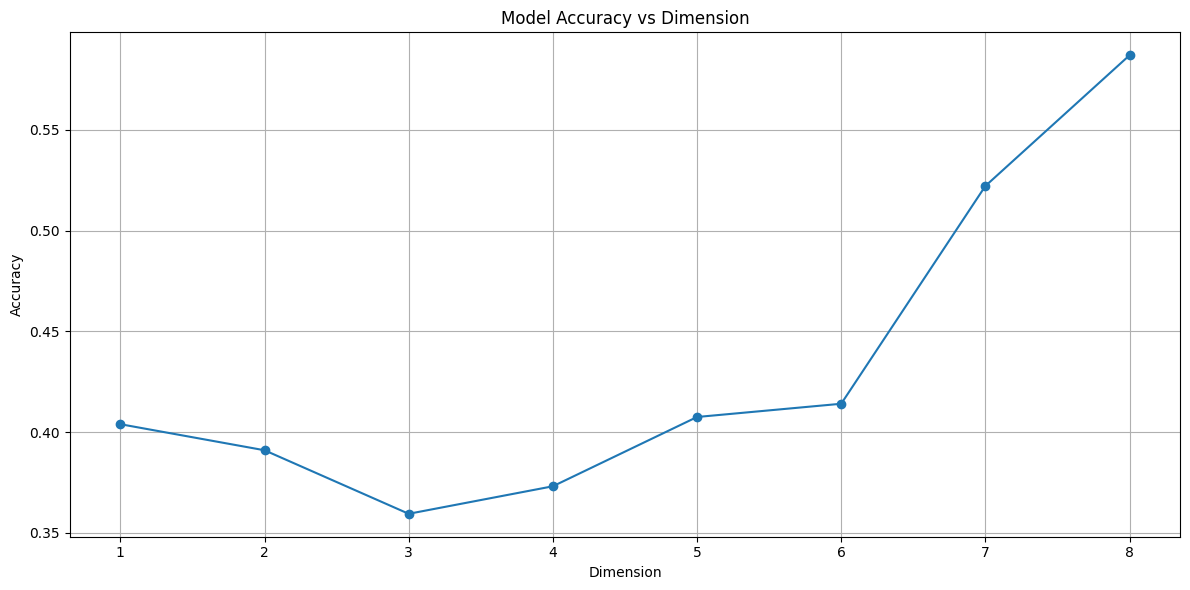

Accuracies for each dimension:
Dimension 1: Accuracy = 0.4039
Dimension 2: Accuracy = 0.3910
Dimension 3: Accuracy = 0.3595
Dimension 4: Accuracy = 0.3731
Dimension 5: Accuracy = 0.4075
Dimension 6: Accuracy = 0.4141
Dimension 7: Accuracy = 0.5221
Dimension 8: Accuracy = 0.5869

Overall Accuracy: 0.5235

Top 20 most important features:
                           feature  importance
21                       dcor(v,X)    0.091414
33                 v~Y_coefficient    0.058295
8                          MI(v,X)    0.055478
22                       dcor(v,Y)    0.051601
24                       MI(v,X)^2    0.038467
29           conditional_MI(v,X|Y)    0.038079
9                          MI(v,Y)    0.034574
31           conditional_MI(X,Y|v)    0.032528
25                       MI(v,Y)^2    0.032181
30           conditional_MI(v,Y|X)    0.032007
18               kendall_corr(v,X)    0.021241
15              spearman_corr(v,X)    0.020974
1                        corr(v,X)    0.020177
4   

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


X = X_train
y = y_train
# Assuming X and y are your features and target variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Get predictions
y_pred = model.predict(X_test)


# Calculate accuracy for each dimension
dimensions = sorted(X_test['dimension'].unique())
accuracies = []

for dim in dimensions:
    mask = X_test['dimension'] == dim
    y_true_dim = y_test[mask]
    y_pred_dim = y_pred[mask]
    acc = accuracy_score(y_true_dim, y_pred_dim)
    accuracies.append(acc)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(dimensions, accuracies, marker='o')
plt.xlabel('Dimension')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs Dimension')
plt.grid(True)
plt.xticks(dimensions)  # Ensure all dimensions are shown on x-axis
plt.tight_layout()
plt.show()

# Print accuracies
print("Accuracies for each dimension:")
for dim, acc in zip(dimensions, accuracies):
    print(f"Dimension {dim}: Accuracy = {acc:.4f}")

# Calculate and print overall accuracy
overall_accuracy = accuracy_score(y_test, y_pred)
print(f"\nOverall Accuracy: {overall_accuracy:.4f}")

# Get feature importances
importances = model.feature_importances_
feature_importances = pd.DataFrame({'feature': X_train.columns, 'importance': importances})
feature_importances = feature_importances.sort_values('importance', ascending=False)

# Display top 20 most important features
print("\nTop 20 most important features:")
print(feature_importances)

# Save the model
import joblib
joblib.dump(model, './resources/random_forest_model.joblib')

print("\nModel and feature importances have been saved.")

In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
import re
# 假设 X_train, y_train 已经准备好

# 清理特征名称
def clean_feature_names(X):
    def clean_name(name):
        name = re.sub(r'[^\w\s-]', '_', name)
        if name[0].isdigit():
            name = 'f_' + name
        return name
    
    X.columns = [clean_name(col) for col in X.columns]
    return X

X_train = clean_feature_names(X_train)

# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# 创建TabNet模型
tabnet_model = TabNetClassifier(
    n_d=64,  # 决策步骤的维度
    n_a=64,  # 注意力步骤的维度
    n_steps=5,  # 总共的决策步骤数
    gamma=1.5,  # 控制稀疏性的参数
    n_independent=2,  # 每个步骤的独立层数
    n_shared=2,  # 共享层数
    cat_idxs=[],  # 分类特征的索引
    cat_dims=[],  # 每个分类特征的唯一值数量
    cat_emb_dim=[],  # 每个分类特征的嵌入维度
    lambda_sparse=1e-3,  # L1正则化参数
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params=dict(
        mode="min", patience=5, min_lr=1e-5, factor=0.5
    ),
    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
    mask_type="entmax",  # "sparsemax" or "entmax"
    device_name='cuda' if torch.cuda.is_available() else 'cpu'
)

# 训练模型
tabnet_model.fit(
    X_train=X_train.values, 
    y_train=y_train.values,
    eval_set=[(X_val.values, y_val.values)],
    eval_name=['val'],
    eval_metric=['balanced_accuracy'],
    max_epochs=100,
    patience=10,
    batch_size=1024,
    virtual_batch_size=256,
    num_workers=0,
    weights=1,
    drop_last=False
)

# 打印训练结果
print(f"Best epoch: {tabnet_model.best_epoch}")
print(f"Best validation balanced accuracy: {tabnet_model.best_cost}")

# 在训练集和验证集上评估模型
y_train_pred = tabnet_model.predict(X_train.values)
y_val_pred = tabnet_model.predict(X_val.values)

train_accuracy = balanced_accuracy_score(y_train, y_train_pred)
val_accuracy = balanced_accuracy_score(y_val, y_val_pred)

print(f"Train balanced accuracy: {train_accuracy:.4f}")
print(f"Validation balanced accuracy: {val_accuracy:.4f}")

# 保存模型
import joblib
# joblib.dump(tabnet_model, './resources/tabnet_model_v0.joblib')

e:\Softwares\Anaconda\CondaEnvs\casual\lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1.98184 | val_balanced_accuracy: 0.21751 |  0:00:08s
epoch 1  | loss: 1.61436 | val_balanced_accuracy: 0.22969 |  0:00:17s
epoch 2  | loss: 1.57693 | val_balanced_accuracy: 0.35237 |  0:00:26s


KeyboardInterrupt: 

In [16]:
import re

def clean_feature_names(X):
    # 函数用于清理特征名称
    def clean_name(name):
        # 移除或替换特殊字符
        name = re.sub(r'[^\w\s-]', '_', name)
        # 确保名称不以数字开头
        if name[0].isdigit():
            name = 'f_' + name
        return name

    X.columns = [clean_name(col) for col in X.columns]
    return X

# 清理特征名称
X_train = clean_feature_names(X_train)


from lightgbm import LGBMClassifier
import lightgbm as lgb
model = LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=6,
    num_leaves=29,
    min_child_samples=20,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=0.1,
    random_state=42,
    n_jobs=-1,
    class_weight='balanced',
    device='gpu',
    gpu_platform_id=1,
    gpu_device_id=0,
)
display(model)

from sklearn.model_selection import GroupKFold
from sklearn.metrics import balanced_accuracy_score
import numpy as np



cv = GroupKFold(n_splits=4)
train_scores = []
val_scores = []

for train_idx, val_idx in cv.split(X_train, y_train, groups=group_train):
    X_train_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    callbacks = [lgb.log_evaluation(period=1), lgb.early_stopping(stopping_rounds=10)]
    
    model.fit(X_train_fold, y_train_fold, callbacks=callbacks, eval_set=[(X_val_fold, y_val_fold)])

    
    y_train_pred = model.predict(X_train_fold)
    y_val_pred = model.predict(X_val_fold)
    
    train_score = balanced_accuracy_score(y_train_fold, y_train_pred)
    val_score = balanced_accuracy_score(y_val_fold, y_val_pred)
    
    train_scores.append(train_score)
    val_scores.append(val_score)
    
    print(f"Fold train balanced accuracy: {train_score:.4f}")
    print(f"Fold validation balanced accuracy: {val_score:.4f}")
    print("---")

print(f"Average train balanced accuracy: {np.mean(train_scores):.4f} ± {np.std(train_scores):.4f}")
print(f"Average validation balanced accuracy: {np.mean(val_scores):.4f} ± {np.std(val_scores):.4f}")

LGBMClassifier(class_weight='balanced', colsample_bytree=0.7, device='gpu',
               gpu_device_id=0, gpu_platform_id=1, learning_rate=0.01,
               max_depth=6, n_estimators=2000, n_jobs=-1, num_leaves=29,
               random_state=42, reg_alpha=0.1, reg_lambda=0.1, subsample=0.7)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 7914
[LightGBM] [Info] Number of data points in the train set: 107040, number of used features: 32
[LightGBM] [Info] Using requested OpenCL platform 1 device 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 30 dense feature groups (3.27 MB) transferred to GPU in 0.007782 secs. 1 sparse feature groups
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start 

KeyboardInterrupt: 

In [17]:
# Uncomment what you need!
def train(
    X_train: typing.Dict[str, pd.DataFrame],
    y_train: typing.Dict[str, pd.DataFrame],
    # number_of_features: int,
    model_directory_path: str,
    # id_column_name: str,
    # prediction_column_name: str,
    # has_gpu: bool,
) -> None:
    # 1) Create the variable embedding:
    return
    X_y_group_train_pathname = "/tmp/X_y_group_train.parquet"
    try:
        print(f"Loading {X_y_group_train_pathname}")
        X_y_group_train = pd.read_parquet(X_y_group_train_pathname)
    except FileNotFoundError:
        print("Creating X_y_group_train")
        names_datasets_train = X_train
        names_graphs_train = y_train
        X_y_group_train = create_all_columns(
            {
                pearson_correlation: names_datasets_train,
                ttest: names_datasets_train,
                mutual_information: names_datasets_train,  # comment this line to greatly reduce computation
                label: names_graphs_train,
                spearman_correlation: names_datasets_train,
                kendall_correlation: names_datasets_train,
                distance_correlation: names_datasets_train,
                conditional_mutual_information: names_datasets_train,
            },
            n_jobs=-1,
        )
        X_y_group_train = remove_outliers(X_y_group_train, ['corr(v,X)', 'corr(v,Y)', 'ttest(v,X)', 'ttest(v,Y)'])
        # 2) Massage X_y_group_train to prepare what is needed by the model:
        print("Adding numeric labels y") # sklearn wants numeric labels
        le = LabelEncoder()
        le.classes_ = np.array([
            'Cause of X', 'Consequence of X', 'Confounder', 'Collider',
            'Mediator', 'Independent', 'Cause of Y', 'Consequence of Y',
        ])
        X_y_group_train["y"] = le.transform(X_y_group_train["label"])

        # reordering columns:
        X_y_group_train = X_y_group_train[["dataset", "variable"] + X_y_group_train.columns.drop(["dataset", "variable", "label", "y"]).tolist() + ["label", "y"]]
        display(X_y_group_train)

        print("Saving X_y_group_train")
        os.makedirs(os.path.dirname(X_y_group_train_pathname), exist_ok=True)
        X_y_group_train.to_parquet(X_y_group_train_pathname)

    print("Extracting X_train, y_train, and group")
    X_train = X_y_group_train.drop(["variable", "dataset", "label", "y"], axis="columns")
    y_train = X_y_group_train["y"]
    group_train = X_y_group_train["dataset"]

    # Model:
    model = RandomForestClassifier(n_estimators=100, max_depth=11, n_jobs=-1, class_weight="balanced")
    model.fit(X_train, y_train)

    joblib.dump(
        model,
        os.path.join(model_directory_path, "model.joblib")
    )


In [20]:
def create_submission(X_y_pred_test):
    """
    From the predicted test set, for each dataset, take predicted
    classes of all variables, create the adjacency matrix, then create
    the submission in the requested format.
    """

    submission = {}
    for name, prediction in tqdm(X_y_pred_test.groupby("dataset"), delay=10):
        variables_labels = prediction[["variable", "label_predicted"]].set_index("variable")
        variables = variables_labels.index.tolist()
        variables_all = ["X", "Y"] + variables

        adjacency_matrix = pd.DataFrame(index=variables_all, columns=variables_all)
        adjacency_matrix.index.name = "parent"
        adjacency_matrix[:] = 0
        adjacency_matrix.loc["X", "Y"] = 1

        for v in variables:
            l = variables_labels.loc[v].item()
            if l == "Cause of X":
                adjacency_matrix.loc[v, "X"] = 1
            elif l == "Cause of Y":
                adjacency_matrix.loc[v, "Y"] = 1
            elif l == "Consequence of X":
                adjacency_matrix.loc["X", v] = 1
            elif l == "Consequence of Y":
                adjacency_matrix.loc["Y", v] = 1
            elif l == "Confounder":
                adjacency_matrix.loc[v, "X"] = 1
                adjacency_matrix.loc[v, "Y"] = 1
            elif l == "Collider":
                adjacency_matrix.loc["X", v] = 1
                adjacency_matrix.loc["Y", v] = 1
            elif l == "Mediator":
                adjacency_matrix.loc["X", v] = 1
                adjacency_matrix.loc[v, "Y"] = 1
            elif l == "Confounder":
                pass

        for i in variables_all:
            for j in variables_all:
                submission[f'{name}_{i}_{j}'] = int(adjacency_matrix.loc[i, j])

    return submission


# Uncomment what you need!
def infer(
    X_test: typing.Dict[str, pd.DataFrame],
    # number_of_features: int,
    model_directory_path: str,
    id_column_name: str,
    prediction_column_name: str,
    # has_gpu: bool,
    # has_trained: bool,
) -> pd.DataFrame:
    model = joblib.load(os.path.join(model_directory_path, "random_forest_model_v0.joblib"))

    names_datasets_test = X_test
    X_group_test = create_all_columns(
        {
                pearson_correlation: names_datasets_train,
                ttest: names_datasets_train,
                mutual_information: names_datasets_train,  # comment this line to greatly reduce computation
                label: names_graphs_train,
                spearman_correlation: names_datasets_train,
                kendall_correlation: names_datasets_train,
                distance_correlation: names_datasets_train,
                conditional_mutual_information: names_datasets_train,
        },
        n_jobs=-1,
    )

    X_test = X_group_test.drop(columns=["dataset", "variable"])
    y_predicted = model.predict(X_test)
    X_y_pred_test = X_group_test
    X_y_pred_test["y_predicted"] = y_predicted

    le = LabelEncoder()
    le.classes_ = np.array([
        'Cause of X', 'Consequence of X', 'Confounder', 'Collider',
        'Mediator', 'Independent', 'Cause of Y', 'Consequence of Y',
    ])

    X_y_pred_test["label_predicted"] = le.inverse_transform(y_predicted)

    submission = create_submission(X_y_pred_test)

    return pd.DataFrame(
        submission.items(),
        columns=[
            id_column_name,
            prediction_column_name
        ]
    )

In [21]:
crunch.test(
    no_determinism_check=True
)

print("Download this notebook and submit it to the platform: https://hub.crunchdao.com/competitions/causality-discovery/submit/via/notebook")

12:53:24 no forbidden library found
12:53:24 
12:53:24 started
12:53:24 running local test
12:53:24 internet access isn't restricted, no check will be done
12:53:24 
12:53:31 starting dag process...


download data\X_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_train.pickle (1523944532 bytes)
already exists: file length match
download data\y_train.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_train.pickle (7017735 bytes)
already exists: file length match
download data\X_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/X_test_reduced.pickle (122341879 bytes)
already exists: file length match
download data\y_test.pickle from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/y_test_reduced.pickle (562930 bytes)
already exists: file length match
download data\example_prediction.parquet from https:crunchdao--competition--production.s3.eu-west-1.amazonaws.com/data-releases/48/example_prediction_reduced.parquet (668981 bytes)
already exists: file length match


12:53:42 call: train
12:53:42 call: infer
12:53:43 duration - time=00:00:19
12:53:43 memory - before="2.54 GB" after="3.52 GB" consumed="1,001.20 MB"


NameError: name 'names_datasets_train' is not defined